In [1]:
"""
Magic commands
"""
%matplotlib inline
%load_ext autoreload
%autoreload 2

"""
Python standard packages
"""
import os
import sys

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output

import scipy.stats as stats
import random

"""
Own packages
"""
sys.path.insert(0, "C:\\code\\speciale\\") # vesl path
sys.path.insert(0, "C:\\Users\\lucas\\OneDrive\\Skrivebord\\repo\\speciale\\") # ljb path

from market_simulation_study.agent import RandomAgent, InvestorAgent, TrendAgent, RLAgent, MarketMakerAgent
from market_simulation_study.environment import MarketEnvironment



"""
Initializations
"""
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)
sns.set_theme("paper","whitegrid")

In [5]:
a = np.random.normal(2, 0.2, size = 100)
b = np.random.normal(1, 0.1, size = 100)

print("VAR1 ", np.var(a - 2))
print("VAR2 ", np.var(b - 1))

VAR1  0.045338268578803936
VAR2  0.008772607855848104


# Simulation 


## Setup

In [3]:
# Declare parameters
n_random_agents = 20
n_investor_agents = 2
n_trend_agents = 3
n_mm_agents = 20
n_rl_agents = 0

n_agents = n_random_agents + n_investor_agents + n_trend_agents + n_rl_agents + n_mm_agents

time_periods = 10000

price_list = [100 + np.random.normal(scale = 0.01) for j in range(100)]
ex_list = np.array([[0]*n_agents, [0]*n_agents])
fee = 0
slippage = 0
mean_buy_price = 99.5
mean_sell_price = 100.5
delta = 1

state0 = {"market_prices": price_list, "volume": ex_list, 'fee': fee, "mean_buy_price": mean_buy_price,
          "mean_sell_price": mean_sell_price, 'slippage': slippage}

agents = []

investor_agents = []

if n_investor_agents >= 1:
    investor_agents.append(InvestorAgent(agent_id = 0,
                                     delta = delta,
                                     intensity = 0.01,
                                     buy_price_margin = 0.010,
                                     sell_price_margin = 0.015,
                                     buy_volume = 5,
                                     sell_volume = 10, 
                                     n_orders = 10))
if n_investor_agents == 2:  
    investor_agents.append(InvestorAgent(agent_id = 1,
                                         delta = delta,
                                         intensity = 0.005,
                                         n_orders = 6,
                                         buy_price_margin = 0.03,
                                         sell_price_margin = 0.05,
                                         buy_volume = 15,
                                         sell_volume = 30,
                                         can_short = True))

random_agents = [RandomAgent(agent_id = j + n_investor_agents,
                             delta = delta,
                             noise_range = (0.0001, 0.0005),
                             mid_price_noise = 0.001) for j in range(n_random_agents)]

trend_agents = [TrendAgent(agent_id = j + n_random_agents + n_investor_agents,
                                 delta = delta,
                                  moving_average_one = np.random.randint(10, 30),
                                  moving_average_two = np.random.randint(50, 100)) for j in range(n_trend_agents)]

mm_agents = [MarketMakerAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents,
                              delta = delta,
                              gamma = 0.001,
                             gamma2 = np.random.uniform(0.75, 3)) for j in range(n_mm_agents)]

rl_agents = [RLAgent(agent_id = j + n_random_agents + n_investor_agents + n_trend_agents + mm_agents,
                                 delta = delta) for j in range(n_rl_agents)]

agents.append(investor_agents)
agents.append(random_agents)
agents.append(trend_agents)
agents.append(mm_agents)
agents.append(rl_agents)

### Initialize agents

In [4]:
env = MarketEnvironment(state0)

agents = [item for sublist in agents for item in sublist]

# Initialize agents
for j in range(n_agents):
        agents[j].update(state0)

## Run simulation

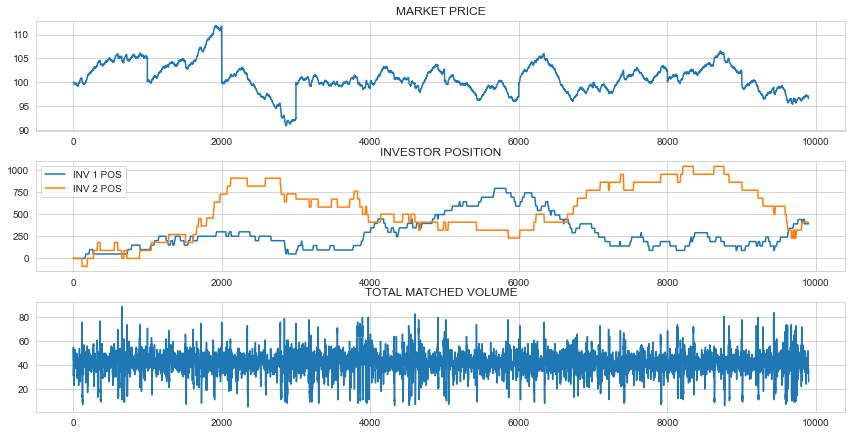

[====================] 100%

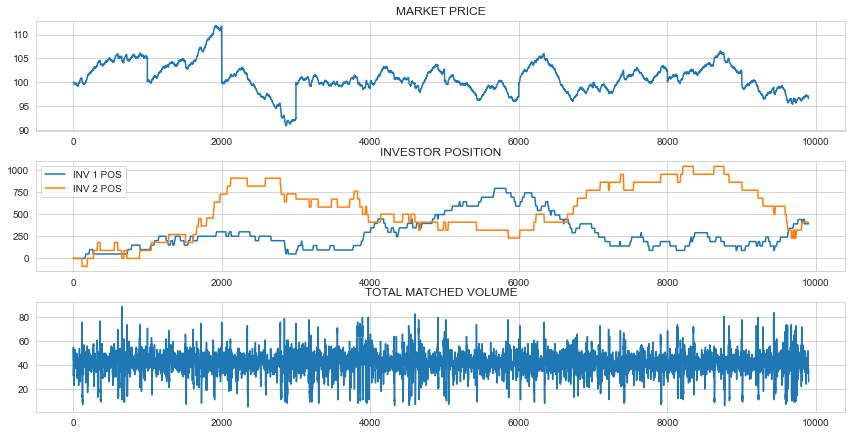

In [7]:
time_periods = 1000
n_episodes = 10
rl_profit = []
market_prices = []
inv1_pos = []
inv2_pos = []
market_volume = []
fig, ax = plt.subplots(3, 1, figsize = (12, 6))
fig.tight_layout()
for _ in range(n_episodes):
    env = MarketEnvironment(state0)
    # Initialize agents
    for j in range(n_agents):
            agents[j].update(state0)
            
    # START EPISODE
    for time in range(time_periods):

        agents, state = env.step(agents)

        for j in range(n_agents):
            agents[j].update(state)


        ########################################
        # PRINT RUNTIME
        ########################################

        j = (time + 1) / time_periods
        sys.stdout.write('\r')
        sys.stdout.write("[%-20s] %d%%" % ('='*int(20*j), 100*j))
        sys.stdout.flush()

        #########################################
        # UPDATE PLOTS
        #########################################

        inv1_pos.append(agents[0].position)
        inv2_pos.append(agents[1].position)
        market_volume.append(state["volume"])
        market_prices.append(state["market_prices"][-1])
        if time % 100 == 0:
            clear_output()
            ax[0].cla()
            ax[0].plot(market_prices)
            ax[0].set(title = "MARKET PRICE")

            ax[1].cla()
            ax[1].set(title = "INVESTOR POSITION")
            ax[1].plot(inv1_pos, label = "INV 1 POS")
            ax[1].plot(inv2_pos, label = "INV 2 POS")
            ax[1].legend()

            ax[2].cla()
            ax[2].set(title = "TOTAL MATCHED VOLUME")
            ax[2].plot(market_volume)

            display(fig)

        

    
#save_state_space
#agents[n_agents - 1].save_state_space()

In [15]:
len(returns)

9900

In [25]:
returns.max()

0    0.081941
dtype: float64

[Text(0.5, 1.0, 'Cumulative Returns')]

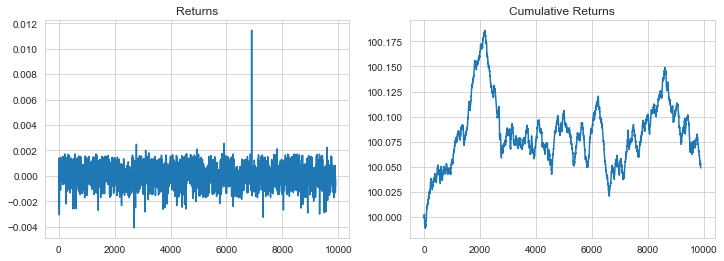

In [39]:
mp = pd.DataFrame(market_prices[100:])
returns = mp / mp.shift(1)  - 1
returns = returns[abs(returns.values) <= 0.0125]
mp = 100 + (returns).cumsum()
fig, ax = plt.subplots(1, 2, figsize = (12, 4))

ax[0].plot(returns)
ax[0].set(title = "Returns")
ax[1].plot(mp)
ax[1].set(title = "Cumulative Returns")
#plt.savefig("plots/returns_cumreturns.png")

In [40]:
def weighted_mean(var, wts):
    """Calculates the weighted mean"""
    return np.average(var, weights=wts)


def weighted_variance(var, wts):
    """Calculates the weighted variance"""
    return np.average((var - weighted_mean(var, wts))**2, weights=wts)

def weighted_skew(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**3, weights=wts) /
            weighted_variance(var, wts)**(1.5))

def weighted_kurtosis(var, wts):
    """Calculates the weighted skewness"""
    return (np.average((var - weighted_mean(var, wts))**4, weights=wts) /
            weighted_variance(var, wts)**(2))

kurt  13.985242039407183
skew  0.16406033420486127


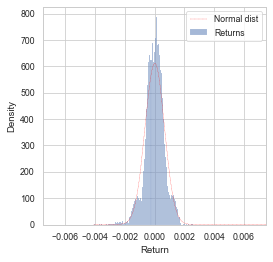

In [55]:
title = "Return dist vs Normal Dist"
avg = np.nanmean(returns)
std = np.std(returns)[0]
n = len(returns)
x = np.linspace(np.max(returns)[0], np.min(returns)[0], n)
norm_dist = stats.norm.pdf(x, avg, std)
kurt = weighted_kurtosis(returns[1:], wts = np.ones_like(returns[1:]))
skew = weighted_skew(returns[1:], wts = np.ones_like(returns[1:]))
fig, ax = plt.subplots( figsize = (4, 4))

sns.histplot(returns, stat = "density", label = "Returns", ax = ax)
ax.plot(x, norm_dist, label = "Normal dist", ls = "--", color = "red", lw = 0.25)
ax.legend()
ax.set(xlim = (-0.0075, 0.0075), xlabel = "Return")
#ax.text(-0.04, 55, f"kurt = {kurt:.1f}", fontsize = 15)
#ax.text(-0.04, 45, f"skew = {skew:.1f}", fontsize = 15)
#

print("kurt ", kurt)
print("skew ", skew)
#fig.tight_layout()
plt.savefig("plots/kurtosis_dist_bf_rl.png")

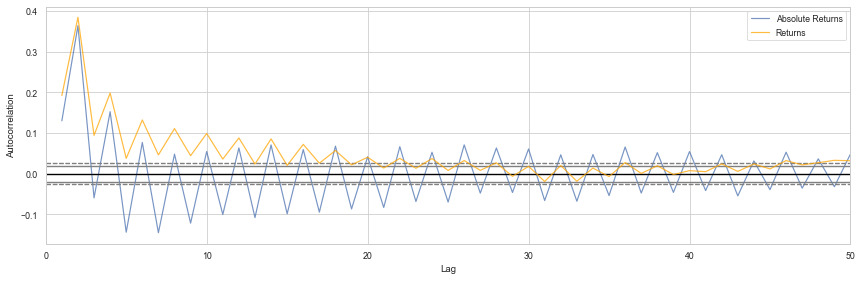

In [56]:

fig, ax = plt.subplots( figsize = (12, 4))

pd.plotting.autocorrelation_plot(np.abs(returns[1:]), ax = ax, label = "Absolute Returns", alpha = 0.75)
pd.plotting.autocorrelation_plot(returns[1:], ax = ax, color = "orange", alpha = 0.75, label = "Returns")
fig.tight_layout()
ax.set_xlim(0, 50)
plt.savefig("plots/autocorel_bf_rl.png")

# Performance overview

In [57]:
stats_df = pd.DataFrame({"id":None, "class":None, "Position":None, "PNL":None}, index = [0]).dropna()
for agent in agents:
    agent.calculate_profit_and_loss(state)
    df_temp = pd.DataFrame({"id": agent.agent_id,
                            "class":agent.agent_class, 
                            "Position":agent.position, 
                            "PNL": agent.pnl, 
                            "latency": agent.latency},
                            index = [agent.agent_id])
    stats_df = stats_df.append(df_temp)

print("PNL SUM: ", stats_df["PNL"].sum())
print("POS SUM: ", stats_df["Position"].sum())
stats_df.sort_values("latency", inplace = True)
np.corrcoef(stats_df.PNL.values, stats_df.latency.values)
display(stats_df)
display(stats_df.groupby("class")["PNL"].mean())

PNL SUM:  3.510081114654895e-12
POS SUM:  0.0


,id,class,Position,PNL,latency
41,41,MM,-1.0,-329.964497,0.558997
29,29,MM,-1.0,-164.024622,0.570811
32,32,MM,-1.0,-190.082214,0.587967
27,27,MM,-1.0,-297.617635,0.593983
26,26,MM,1.0,368.241318,0.602230
36,36,MM,-1.0,-368.940143,0.663229
33,33,MM,-1.0,-145.838927,0.681463
35,35,MM,1.0,309.702423,0.713718
31,31,MM,1.0,-282.444986,0.726216
44,44,MM,1.0,29.062673,0.733590


class
Investor   -5620.070076
MM           -94.688633
Random       623.742243
Trend        219.689314
Name: PNL, dtype: float64